<img src="https://datascientest.fr/train/assets/logo_datascientest.png" style="height:150px"> 
<hr style="border-width:2px;border-color:##75DFC1">
<center> <h1> Projet COVID </h1> </center> <br>
<center> <h2> Deuxième prototype</h2> </center> <br>
<hr style="border-width:2px;border-color:##75DFC1">

Deuxième implémentation d'un CNN sur les images
<hr style="border-width:2px;border-color:##75DFC1">

>Grad-CAM

>Transfer Learning

Visualisation les biais du premier prototype grâce à un Grad-CAM (Gradient-weighted Class Activation Mapping), qui utilise la dernière couche de convolution pour visualiser les régions de l'image de départ qui sont "importantes" pour la prédiction du modèle.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import cv2

os.chdir('/home/baptiste/github/covid-project/COVID-19 Radiography Database')

df = pd.read_csv('img_metadata.csv', index_col = 0)

In [3]:
import keras

clf = keras.models.load_model('premier_prototype.h5')

Image shape is: (1024, 1024)
exposure: 110.29748344421387


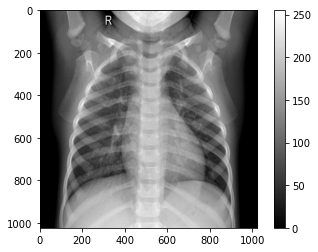

In [4]:
image_name = 'NORMAL/NORMAL (493).png'
img = cv2.imread(image_name,0)
print('Image shape is:', img.shape)
print('exposure:', np.mean(img))

plt.imshow(img,cmap='gray')
plt.colorbar();

Image shape is: (160, 160)
exposure: 0.4325429507810744


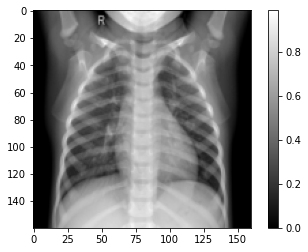

In [5]:
from skimage import transform
X = img/255
im_shape = (160, 160)
X = transform.resize(X, im_shape)

print('Image shape is:', X.shape)
print('exposure:', np.mean(X))
plt.imshow(X,cmap='gray')
plt.colorbar();

In [7]:
pred = clf.predict(X.reshape((1, 160, 160, 1)))
pred # prédit en normal

array([[9.9995363e-01, 3.0822079e-07, 4.5992576e-05]], dtype=float32)

Image shape is: (256, 256)
exposure: 145.89463806152344


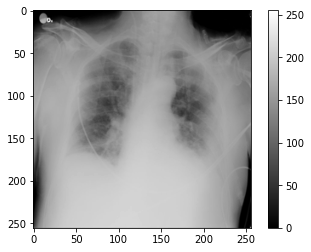

In [8]:
image_name = 'COVID/COVID (1).png'
img = cv2.imread(image_name,0)
print('Image shape is:', img.shape)
print('exposure:', np.mean(img))

plt.imshow(img,cmap='gray')
plt.colorbar();

Image shape is: (160, 160)
exposure: 0.5721086866025196


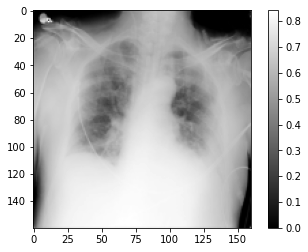

In [9]:
X = img/255
im_shape = (160, 160)
X = transform.resize(X, im_shape)

print('Image shape is:', X.shape)
print('exposure:', np.mean(X))
plt.imshow(X,cmap='gray')
plt.colorbar();

In [10]:
pred = clf.predict(X.reshape((1, 160, 160, 1)))
pred # prédit en covid

array([[1.2005110e-05, 9.9994290e-01, 4.5033874e-05]], dtype=float32)

Utilisons l'algorithme de Grad-CAM proposé sur le site de Keras

In [8]:
import tensorflow as tf

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def decode_predictions(pred):
    if np.argmax(pred) == 1:
        return 'covid'
    elif np.argmax(pred) == 2:
        return 'pneumo'
    else:
        return 'normal'
    
def get_img_array(img, im_shape):
    X = img/255
    X = transform.resize(X, im_shape)
    return X.reshape((1, im_shape[0], im_shape[1], 1))

In [14]:
clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 158, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 38, 38, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46208)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5

In [26]:
last_conv_layer_name = "conv2d_1"
classifier_layer_names = [
    "max_pooling2d_1",
    "dropout",
    "flatten",
    "dense",
    "dropout_1",
    "dense_1"]

Predicted: covid


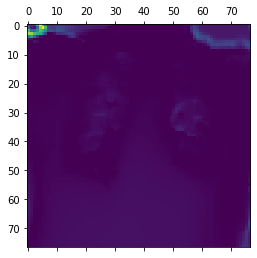

In [27]:
# Prepare image
img_array = X.reshape((1, 160, 160, 1))

# Print what the top predicted class is
pred = clf.predict(img_array)
print("Predicted:", decode_predictions(pred))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, clf, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

On voit que sur cette image, la zone d'intérêt est concentrée sur le bord supérieur gauche, qui n'a rien à voir avec le diagnostique du covid (qui devrait être dans les poumons).

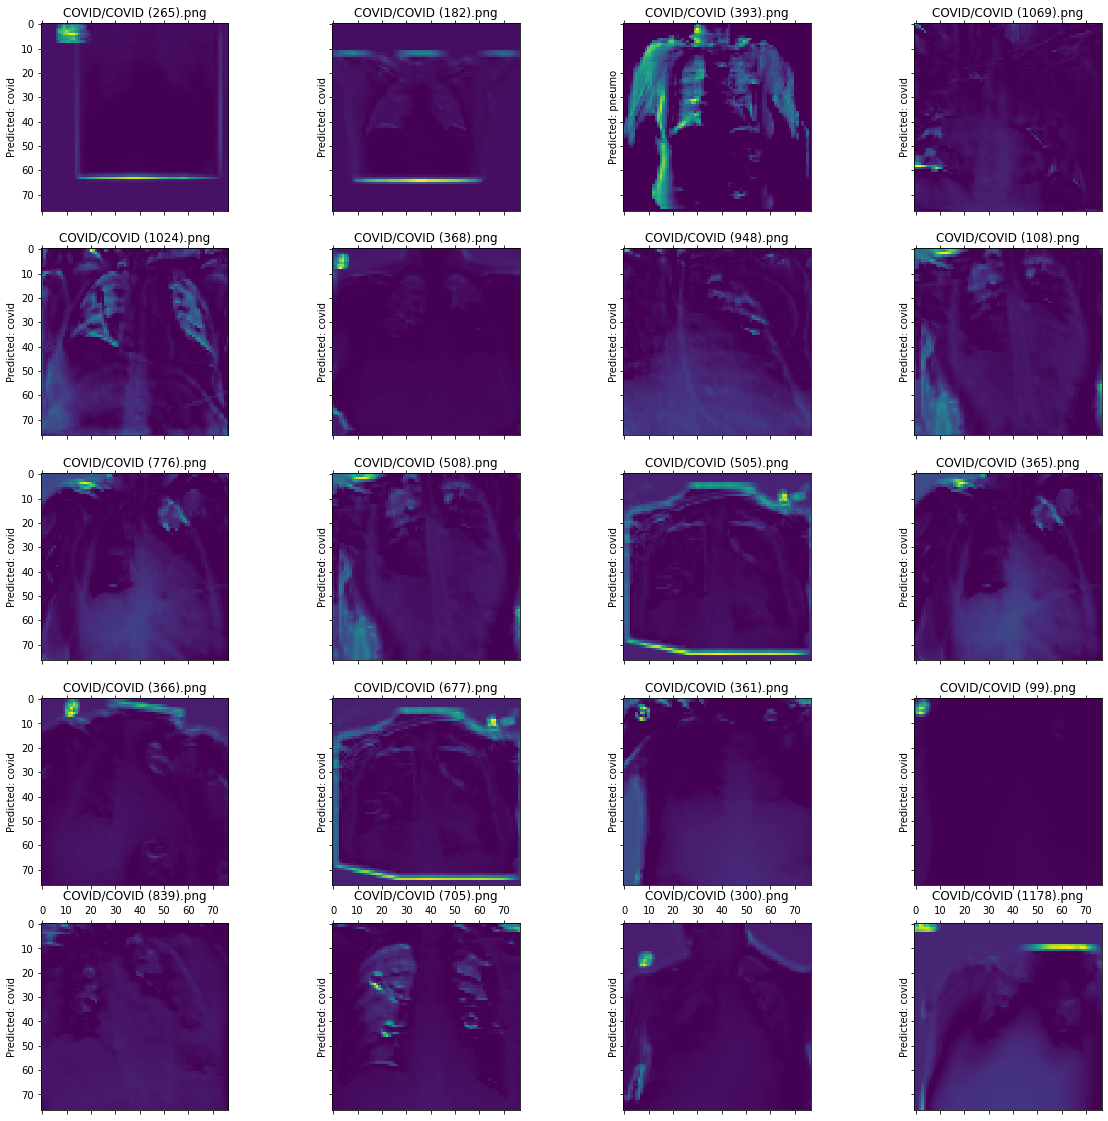

In [37]:
idx = list(df.loc[df['Class'] == 'covid', 'area'].sort_values().index)

fig, axes = plt.subplots(5, 4, figsize=(20, 20), sharex = True, sharey = True)

axes = axes.ravel()

for ii in range(20):
    image_name = idx[ii] 
    img = cv2.imread(image_name,0)
    img_array = get_img_array(img, im_shape)
    axes[ii].set_title(image_name)
    heatmap = make_gradcam_heatmap(
        img_array, clf, last_conv_layer_name, classifier_layer_names)
    axes[ii].matshow(heatmap)
    pred = clf.predict(img_array)
    axes[ii].set_ylabel("Predicted: " + decode_predictions(pred))
    

On voit que pour ces 20 images covid, le choix de l'algorithme est majoritairement réalisé grâce aux bords des images.

Deuxième prototype en transfert learning, sur le dataset avec des histogrammes équilibrés et des images croppées sur les poumons

In [6]:
os.chdir('/home/baptiste/github/covid-project/cropped_dataset/')

In [7]:
df.head()

Class  height  width  channel   B&W  luminosite  \
path                                                                     
COVID/COVID (934).png  covid   331.0  331.0      3.0  True  106.488376   
COVID/COVID (296).png  covid   256.0  256.0      3.0  True  119.666504   
COVID/COVID (74).png   covid   256.0  256.0      3.0  True  153.078995   
COVID/COVID (261).png  covid   256.0  256.0      3.0  True  186.787781   
COVID/COVID (978).png  covid   331.0  331.0      3.0  True  159.006818   

                          area  keep  
path                                  
COVID/COVID (934).png  37841.0     1  
COVID/COVID (296).png  39366.0     1  
COVID/COVID (74).png   38131.0     1  
COVID/COVID (261).png  27607.0     1  
COVID/COVID (978).png  14699.0     1

In [5]:
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras import backend as K
import tensorflow as tf
from skimage import transform
from keras import optimizers

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   rotation_range=15,                   # le plus important
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
#                                   brightness_range = [0.9, 1.1],       # avant ou après le rescale ?
                                   horizontal_flip=False,               # pas de flip pour des images médicales
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale = 1./255)

In [6]:
data = df.loc[df.keep == 1, 'Class'].reset_index()
data['Class'] = data['Class'].replace({'covid' : 1, 'normal' : 0, 'pneumo' : 2})

data_train, data_test = train_test_split(data, test_size=0.2, random_state=123)

In [7]:
batch_size = 8

data_train["Class"] = data_train["Class"].astype(str)
data_test["Class"] = data_test["Class"].astype(str)

training_set = train_datagen.flow_from_dataframe(dataframe=data_train,
                                                 directory="",
                                                 x_col = "path",
                                                 y_col = "Class",
                                                 target_size = (226, 226),
                                                 batch_size = batch_size, 
                                                 color_mode='grayscale',
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_dataframe(dataframe=data_test,
                                            directory="",
                                            x_col = "path",
                                            y_col = "Class",
                                            target_size = (226, 226),
                                            batch_size = batch_size,
                                            color_mode='grayscale',
                                            class_mode = 'categorical')

Found 2988 validated image filenames belonging to 3 classes.
Found 747 validated image filenames belonging to 3 classes.


<ipython-input-7-5265b15a2885>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train["Class"] = data_train["Class"].astype(str)
<ipython-input-7-5265b15a2885>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["Class"] = data_test["Class"].astype(str)


In [11]:
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling="avg")

base_model.trainable = False

model = Sequential()
model.add(Conv2D(filters = 3, 
                  kernel_size = (3, 3), 
                  padding = 'valid', 
                  input_shape = (226, 226, 1), 
                  activation = 'relu'))
model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(units = 1024, activation = 'relu'))
# model.add(Dropout(rate=0.2))
# model.add(Dense(units = 512, activation = 'relu'))
# model.add(Dropout(rate=0.2))
# model.add(Dense(units = 256, activation = 'relu'))
# model.add(Dropout(rate=0.2))
# model.add(Dense(units = 128, activation = 'relu'))
# model.add(Dropout(rate=0.2))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 3, activation = 'sigmoid'))

# Compilation
model.compile(loss = 'categorical_crossentropy', 
                   optimizer = 'adam', 
                   metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 3)       30        
_________________________________________________________________
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense_3 (Dense)              (None, 64)                65600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

L'idée de la première couche de convolution (conv2d_1) est de transformer les images noir et blanc en couleur, pour tirer tout le potentiel du réseau densenet121, qui a été entrainer sur des images couleur. De plus, je suis curieux de voir comment le réseau peut "colorier" les images.

In [4]:
from tensorflow.keras import callbacks

# Save automatically the weights
checkpoint = callbacks.ModelCheckpoint(filepath = 'checkpoint', 
                                       monitor = 'val_loss',
                                       save_best_only = True,
                                       save_weights_only = False,
                                       mode = 'min',
                                       save_freq = 'epoch')

In [13]:
# Entraînement
history = model.fit(training_set, 
                    epochs = 10,
                   workers = -1,
                   steps_per_epoch = len(data_train)//batch_size,
                   validation_data = test_set,
                   validation_steps = len(data_test)//batch_size,
                   callbacks = [checkpoint])

Epoch 1/10
373/373 [==============================] - 345s 915ms/step - loss: 0.6849 - accuracy: 0.6780 - val_loss: 0.3511 - val_accuracy: 0.8683
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 2/10
373/373 [==============================] - 340s 911ms/step - loss: 0.3739 - accuracy: 0.8463 - val_loss: 0.3147 - val_accuracy: 0.8871
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 3/10
373/373 [==============================] - 338s 907ms/step - loss: 0.3564 - accuracy: 0.8650 - val_loss: 0.3173 - val_accuracy: 0.8669
Epoch 4/10
373/373 [==============================] - 339s 908ms/step - loss: 0.3454 - accuracy: 0.8601 - val_loss: 0.3186 - val_accuracy: 0.8602
Epoch 5/10
373/373 [==============================] - 338s 907ms/step - loss: 0.3078 - accuracy: 0.8738 - val_loss: 0.3326 - val_accuracy: 0.8629
Epoch 6/10
373/373 [==============================] - 339s 908ms/step - loss: 0.3037 - accuracy: 0.8843 - val_loss: 0.3387 - val_accuracy: 0.8602
Epoch 7/10
373/373

Le transfert learning semble bien fonctionner, mais je n'arrive pas à utiliser l'algorithme du Grad-CAM, puisque la dernière couche de convolution est dans la couche densenet121, et impossible d'y accéder...

Nous allons donc regénérer le modèle pour avoir le détail des couches dans le densenet121

Le problème avec l'import du densenet121, est qu'il n'est pas en premier dans le modèle, je ne peux donc pas importer à la fois les poids de imagenet et définir un input_tensor (sortie de la couche conv2d). Je vais donc faire l'import en 2 fois, d'abord pour avoir les poids imagenet, puis modifier ces poids dans le réseau de transfer learning.

In [9]:
densenet121 = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                               input_tensor = None,
                                               include_top=False,
                                               weights='imagenet',
                                               pooling="avg")
densenet121.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [10]:
weights_0 = densenet121.get_weights()
weights_0[0]

array([[[[ 7.82755613e-02,  1.41905621e-02,  2.77232146e-03, ...,
          -7.34727364e-03, -1.54294539e-02, -2.66701411e-02],
         [ 1.64177045e-01, -7.71937100e-03, -4.68205148e-03, ...,
           1.56621709e-02, -1.30844340e-02,  1.28259331e-01],
         [ 4.37899120e-02, -7.88586214e-03, -7.51366140e-03, ...,
          -1.51410159e-02, -1.59265753e-02, -9.03300792e-02]],

        [[ 1.49493396e-01,  2.08460707e-02, -8.21969565e-03, ...,
          -3.26420851e-02, -1.16108721e-02, -3.74168977e-02],
         [ 2.48144880e-01,  2.11681356e-03, -9.93694644e-03, ...,
          -3.68802100e-02, -2.01364420e-03,  7.61707202e-02],
         [ 1.12597026e-01,  6.96969219e-03,  1.50776226e-02, ...,
          -1.13535514e-02, -9.01070051e-03, -4.00191024e-02]],

        [[ 1.66112572e-01,  2.03311425e-02,  1.05769075e-02, ...,
           3.73937041e-02, -1.37213594e-03, -1.14080589e-02],
         [ 2.65383482e-01, -1.55173626e-03,  6.22032210e-04, ...,
           6.47445172e-02,  1.3303

In [11]:
dense_input = tf.keras.layers.Input(shape=(226, 226, 1))
dense_filter = Conv2D(filters = 3, kernel_size = (3, 3), padding='valid')(dense_input)
base_model = tf.keras.applications.DenseNet121(input_shape=None,
                                               input_tensor = dense_filter,
                                               include_top=False,
                                               weights=None,
                                               pooling="avg")
# output = base_model(dense_filter)

model = Model(dense_input, base_model.output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 226, 226, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 3)  30          input_2[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
______________________________________________________________________________________________

Modification des poids dans le réseau :

In [12]:
weights_1 = model.get_weights()
for ii in range(2, len(weights_1)):
    weights_1[ii] = weights_0[ii-2]
model.set_weights(weights_1)

In [13]:
weights_1 = model.get_weights()
weights_1[2]

array([[[[ 7.82755613e-02,  1.41905621e-02,  2.77232146e-03, ...,
          -7.34727364e-03, -1.54294539e-02, -2.66701411e-02],
         [ 1.64177045e-01, -7.71937100e-03, -4.68205148e-03, ...,
           1.56621709e-02, -1.30844340e-02,  1.28259331e-01],
         [ 4.37899120e-02, -7.88586214e-03, -7.51366140e-03, ...,
          -1.51410159e-02, -1.59265753e-02, -9.03300792e-02]],

        [[ 1.49493396e-01,  2.08460707e-02, -8.21969565e-03, ...,
          -3.26420851e-02, -1.16108721e-02, -3.74168977e-02],
         [ 2.48144880e-01,  2.11681356e-03, -9.93694644e-03, ...,
          -3.68802100e-02, -2.01364420e-03,  7.61707202e-02],
         [ 1.12597026e-01,  6.96969219e-03,  1.50776226e-02, ...,
          -1.13535514e-02, -9.01070051e-03, -4.00191024e-02]],

        [[ 1.66112572e-01,  2.03311425e-02,  1.05769075e-02, ...,
           3.73937041e-02, -1.37213594e-03, -1.14080589e-02],
         [ 2.65383482e-01, -1.55173626e-03,  6.22032210e-04, ...,
           6.47445172e-02,  1.3303

In [14]:
for layer in model.layers[2:]:
     layer.trainable = False    

In [16]:
x = Dense(units = 64, activation = 'relu')(model.layers[-1].output)
x = Dropout(rate=0.2)(x)
x = Dense(units = 32, activation = 'relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(units = 3, activation = 'sigmoid')(x)
classifier = Model(inputs=model.input, outputs=x)

#Compilation
classifier.compile(loss = 'categorical_crossentropy', 
                   optimizer = 'adam', 
                   metrics = ['accuracy'])

classifier.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 226, 226, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 3)  30          input_2[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
____________________________________________________________________________________________

In [17]:
del densenet121
del base_model
del model

In [19]:
# Entraînement
history = classifier.fit(training_set, 
                    epochs = 10,
                   workers = -1,
                   steps_per_epoch = len(data_train)//batch_size,
                   validation_data = test_set,
                   validation_steps = len(data_test)//batch_size,
                   callbacks = [checkpoint])

Epoch 1/10
373/373 [==============================] - 348s 923ms/step - loss: 0.7344 - accuracy: 0.6502 - val_loss: 0.3707 - val_accuracy: 0.8495
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 2/10
373/373 [==============================] - 341s 915ms/step - loss: 0.3931 - accuracy: 0.8462 - val_loss: 0.3172 - val_accuracy: 0.8858
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 3/10
373/373 [==============================] - 341s 915ms/step - loss: 0.3747 - accuracy: 0.8432 - val_loss: 0.2728 - val_accuracy: 0.9019
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 4/10
373/373 [==============================] - 343s 919ms/step - loss: 0.3570 - accuracy: 0.8645 - val_loss: 0.3245 - val_accuracy: 0.8777
Epoch 5/10
373/373 [==============================] - 342s 916ms/step - loss: 0.3322 - accuracy: 0.8794 - val_loss: 0.2765 - val_accuracy: 0.8898
Epoch 6/10
373/373 [==============================] - 342s 917ms/step - loss: 0.3004 - accuracy: 0.8830 - val_l

In [20]:
classifier.save('deuxieme_prototype.h5')

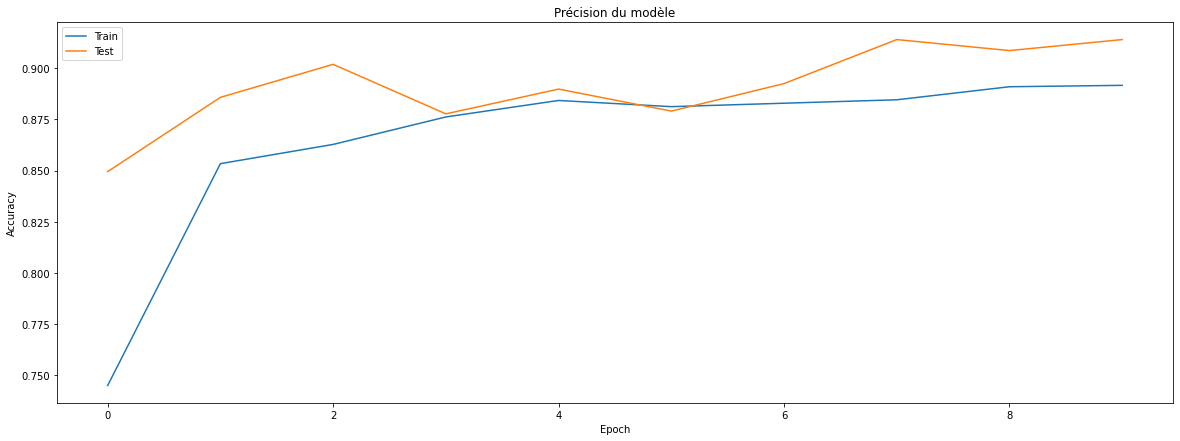

In [21]:
plt.figure(figsize = (20,7))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Précision du modèle")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc = "upper left")
plt.show()

In [23]:
last_conv_layer_name = "bn"
classifier_layer_names = [
    "relu",
    "avg_pool",
    "dense_3",
    "dropout_2",
    "dense_4",
    "dropout_3",
    "dense_5"]

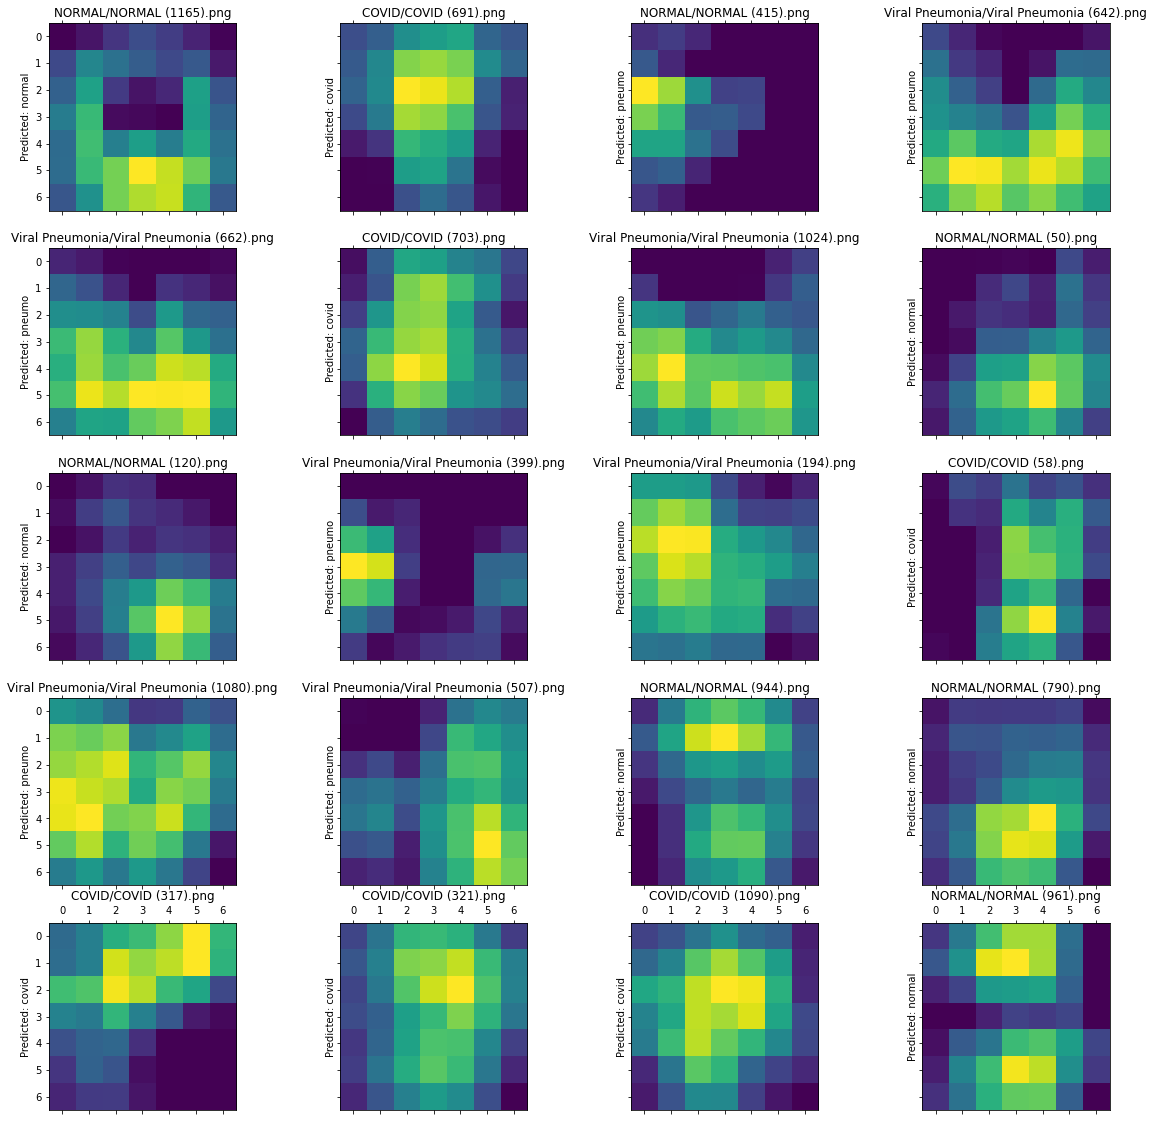

In [26]:
idx = list(df.loc[df.keep == 1].index)

idx = random.sample(idx, 20)

im_shape = (226, 226, 1)

fig, axes = plt.subplots(5, 4, figsize=(20, 20), sharex = True, sharey = True)

axes = axes.ravel()

for ii in range(20):
    image_name = idx[ii] 
    img = cv2.imread(image_name,0)
    img_array = get_img_array(img, im_shape)
    axes[ii].set_title(image_name)
    heatmap = make_gradcam_heatmap(
        img_array, classifier, last_conv_layer_name, classifier_layer_names)
    axes[ii].matshow(heatmap)
    pred = classifier.predict(img_array)
    axes[ii].set_ylabel("Predicted: " + decode_predictions(pred))
    

Utilisation d'un autre algorithme de GradCAM, qui va chercher lui-même la dernière couche de convolution

In [47]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8, normalize=True):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(inputs=[self.model.input], outputs=[self.model.get_layer(self.layerName).output,
                                                              self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            inputs = np.expand_dims(inputs, axis=0)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # if gradients are too small (GradCAM is zero everywhere)
        # equal to changing the value of 'eps' func arg
        grads = grads / (grads.numpy().max() - grads.numpy().min())
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        h, w = image.shape[:2]
        heatmap = cv2.resize(cam.numpy(), (w, h))
#         print('avg heatmap value:', np.mean(heatmap))
#         print('max heatmap value:', np.max(heatmap))
        # ignore certain values lower than a threshold to get sharper heatmaps
        # heatmap[np.where(heatmap < 1)] = 0
        if normalize:
            # normalize the heatmap such that all values lie in the range
            # [0, 1], scale the resulting values to the range [0, 255],
            # and then convert to an unsigned 8-bit integer
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255)
        return heatmap.astype("uint8")

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        # if the input image is grey-scale, convert it to 3-dim
        if len(image.shape) == 2 or image.shape[-1] != 3:
            image = cv2.cvtColor(src=image, code=cv2.COLOR_GRAY2RGB)
        # if image px values are in [0, 1], upscale to [0, 255]
        if np.max(image) <= 1.0:
            image = image * 255.0
        output = cv2.addWeighted(image.astype('uint8'), alpha, heatmap, 1 - alpha, 0)
        return output

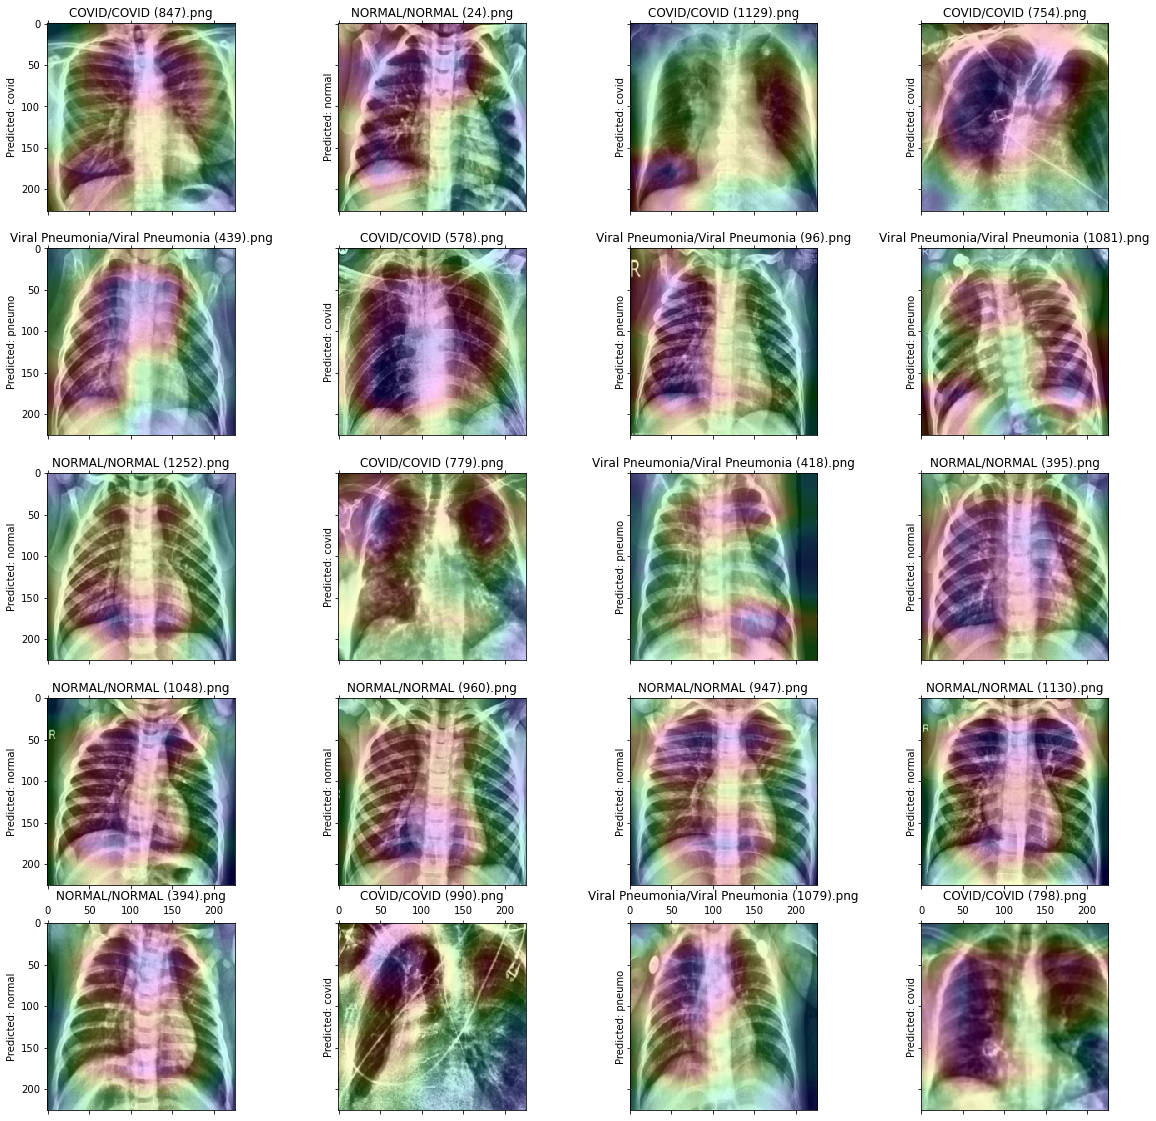

In [48]:
idx = list(df.loc[df.keep == 1].index)

idx = random.sample(idx, 20)

im_shape = (226, 226, 1)

fig, axes = plt.subplots(5, 4, figsize=(20, 20), sharex = True, sharey = True)

axes = axes.ravel()

for ii in range(20):
    image_name = idx[ii] 
    img = cv2.imread(image_name,0)
    img_array = get_img_array(img, im_shape)
    axes[ii].set_title(image_name)
    cam = GradCAM(model=classifier, classIdx=np.argmax(pred), layerName=None)
    heatmap = cam.compute_heatmap(image=img_array[0], normalize=True)
    overlaid_heatmap = cam.overlay_heatmap(heatmap=heatmap, image=cv2.resize(img, (226,226), interpolation = cv2.INTER_AREA), alpha=0.8, 
                                           colormap=cv2.COLORMAP_HSV)
    axes[ii].matshow(overlaid_heatmap)
    pred = classifier.predict(img_array)
    axes[ii].set_ylabel("Predicted: " + decode_predictions(pred))
    

On voit que maintenant, grâce au prétraitement des images et au transfert learning, la décision du réseau est majoritairement prise grâce aux pixels des poumons

In [49]:
for layer in classifier.layers:
    print(layer.name)

input_2
conv2d
zero_padding2d_2
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_3
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_con

In [19]:
import keras

classifier = keras.models.load_model('deuxieme_prototype.h5')

In [21]:
intermediate_layer_model = Model(inputs=classifier.input, outputs=classifier.layers[1].output)

In [22]:
intermediate_layer_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 226, 226, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 3)       30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


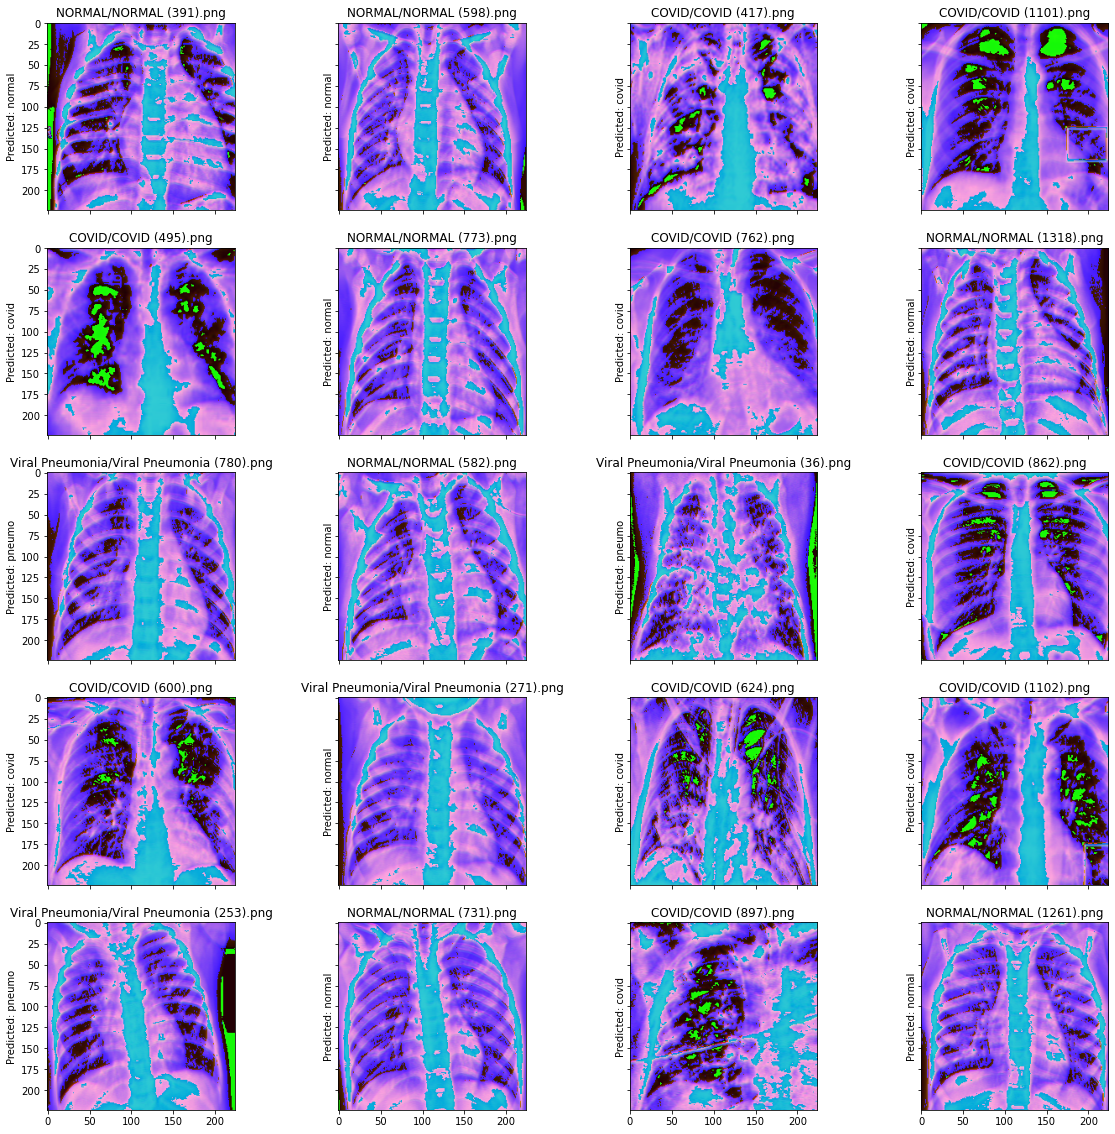

In [24]:
idx = list(df.loc[df.keep == 1].index)

idx = random.sample(idx, 20)

im_shape = (226, 226, 1)

fig, axes = plt.subplots(5, 4, figsize=(20, 20), sharex = True, sharey = True)

axes = axes.ravel()

for ii in range(20):
    image_name = idx[ii] 
    img = cv2.imread(image_name,0)
    img_array = get_img_array(img, im_shape)
    axes[ii].set_title(image_name)
    img_color = intermediate_layer_model.predict(img_array)
    axes[ii].imshow((img_color[0]*255).astype(np.uint8))
    pred = classifier.predict(img_array)
    axes[ii].set_ylabel("Predicted: " + decode_predictions(pred))
    

Voici comment le réseau voit les images en couleur. On peut voir qu'il y a des choses intéressantes en vert, majoritairement présent sur les covid, mais que ce vert se retrouve sur certaine images sur les bords de l'image. On a encore ce problème de détection en bordure...